In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Classification Algorithms. Part III

- [Grid Search](#Efficiently-searching-for-optimal-hyper-parameters:-GridSearchCV)
- [Searching multiple parameters simultaneously](#Searching-multiple-parameters-simultaneously)
- [Randomized Grid Search](#Randomized-Grid-Search:-Randomized-search-on-hyper-parameters.)

## Efficiently searching for optimal hyper-parameters: GridSearchCV

In [2]:
# load the pima indian dataset
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/pima.csv'
pima = pd.read_csv(url)
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# define X and y
feature_cols = ['pregnant','glucose','bp','skin','insulin','bmi','age']
X = pima[feature_cols]
y = pima.label

In [4]:
# import and instantiate the knn classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

In [5]:
# import GridSearch
from sklearn.model_selection import GridSearchCV

In [6]:
# define the parameter values that should be searched
k_range = list(range(1, 51))
print(k_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [7]:
# create a parameter grid dictionary that maps the parameter names to the values that should be searched
param_grid = {'n_neighbors':k_range}
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]}


In [10]:
# instantiate the grid 
grid = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

In [11]:
# fit the grid 
grid.fit(X,y)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.4s finished


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy', verbose=1)

In [12]:
# optional: put scores into a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'params']] # scores into a DataFrame

,mean_test_score,params
0,0.679665,{'n_neighbors': 1}
1,0.712235,{'n_neighbors': 2}
2,0.701760,{'n_neighbors': 3}
3,0.718712,{'n_neighbors': 4}
4,0.720062,{'n_neighbors': 5}
5,0.735714,{'n_neighbors': 6}
6,0.739627,{'n_neighbors': 7}
7,0.738312,{'n_neighbors': 8}
8,0.737047,{'n_neighbors': 9}
9,0.743472,{'n_neighbors': 10}


In [13]:
# examine the best model hyperparameters
print(grid.best_score_)
print(grid.best_params_)

0.7552973342447027
{'n_neighbors': 17}


In [14]:
# model with best hyperparameters
best_clf = grid.best_estimator_

## Searching multiple parameters simultaneously

In [15]:
# define the parameter values that should be searched
k_rankge = list(range(1,51))
weights_options = ['uniform','distance']

In [16]:
# create a parameter grid
param_grid = {'n_neighbors' : k_range, 'weights' : weights_options}
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'weights': ['uniform', 'distance']}


In [17]:
# instantiate and fit the grid
grid = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [18]:
# view the results
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'params']]

,mean_test_score,params
0,0.679665,"{'n_neighbors': 1, 'weights': 'uniform'}"
1,0.679665,"{'n_neighbors': 1, 'weights': 'distance'}"
2,0.712235,"{'n_neighbors': 2, 'weights': 'uniform'}"
3,0.679665,"{'n_neighbors': 2, 'weights': 'distance'}"
4,0.701760,"{'n_neighbors': 3, 'weights': 'uniform'}"
...,...,...
95,0.744891,"{'n_neighbors': 48, 'weights': 'distance'}"
96,0.731921,"{'n_neighbors': 49, 'weights': 'uniform'}"
97,0.744874,"{'n_neighbors': 49, 'weights': 'distance'}"
98,0.722796,"{'n_neighbors': 50, 'weights': 'uniform'}"


In [19]:
# examine the best model hyperparameter
print(grid.best_score_)
print(grid.best_params_)

0.7552973342447027
{'n_neighbors': 17, 'weights': 'uniform'}


In [20]:
# best knn model
best_clf = grid.best_estimator_

## Randomized Grid Search: Randomized search on hyper parameters.

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [22]:
grid = RandomizedSearchCV(knn_clf,
                          param_grid, 
                          cv=10, 
                          n_iter=20, 
                          scoring='accuracy',
                          verbose=1,
                          n_jobs=-1)
grid.fit(X, y)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29, 30, ...],
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

In [23]:
# view the results
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'params']]

,mean_test_score,params
0,0.737081,"{'weights': 'uniform', 'n_neighbors': 27}"
1,0.730537,"{'weights': 'uniform', 'n_neighbors': 28}"
2,0.744839,"{'weights': 'distance', 'n_neighbors': 14}"
3,0.748770,"{'weights': 'distance', 'n_neighbors': 17}"
4,0.750120,"{'weights': 'uniform', 'n_neighbors': 22}"
5,0.750034,"{'weights': 'distance', 'n_neighbors': 35}"
6,0.748735,"{'weights': 'distance', 'n_neighbors': 36}"
7,0.747488,"{'weights': 'distance', 'n_neighbors': 20}"
8,0.679665,"{'weights': 'uniform', 'n_neighbors': 1}"
9,0.744805,"{'weights': 'uniform', 'n_neighbors': 15}"


In [24]:
# examine the best model hyperparameter
print(grid.best_score_)
print(grid.best_params_)

0.7552802460697198
{'weights': 'distance', 'n_neighbors': 16}


## Example: Predicting the age of abalone from physical measurements

Predicting the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age.

In [99]:
# load abalone data
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/abalone.csv'
abalone = pd.read_csv(url)
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [100]:
abalone.Rings.unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24], dtype=int64)

<AxesSubplot:>

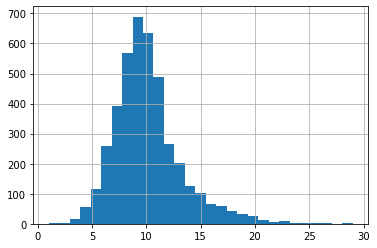

In [101]:
# age/rings distribution
abalone.Rings.hist(bins=29)

In [109]:
# to simplify the problem, let's create age bins:
def age(rings):
    if rings<=5:
        return '<=5'
    elif rings<=10:
        return '6-10'
    elif rings<=15:
        return '11-15'
    else:
        return '>15'

In [110]:
age(15)

'11-15'

In [111]:
abalone['Rings'] = abalone.Rings.apply(age)

In [112]:
abalone.Rings.value_counts()

6-10     2541
11-15    1186
>15       261
<=5       189
Name: Rings, dtype: int64

In [113]:
# feature matrix X/target vector y
X = abalone[['Length','Diameter','Whole weight','Shucked weight','Viscera weight','Shell weight']]
y = abalone.Rings

In [114]:
# train/test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [115]:
# instantiate and fit the grid
grid = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:   11.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.5s finished


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [116]:
# examine the best model hyperparameter
print(grid.best_score_)
print(grid.best_params_)

0.7103874565027167
{'n_neighbors': 23, 'weights': 'uniform'}


In [117]:
best_clf = grid.best_estimator_

In [118]:
y_test_pred = best_clf.predict(X_test)

In [119]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_test,y_test_pred,labels=['<5','6-10','11-15','>15'])

array([[  0,   0,   0,   0],
       [  0, 565,  76,   0],
       [  0, 148, 135,   4],
       [  0,  10,  41,   7]], dtype=int64)

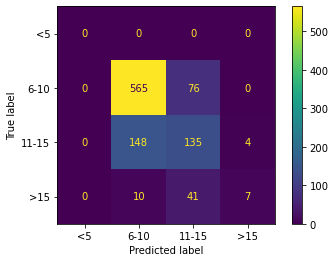

In [120]:
# visualize confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_clf, X_test, y_test, labels=['<5','6-10','11-15','>15'])